In [16]:
import os
import cv2
import numpy as np
import mediapipe as mp
import pandas as pd
from tqdm import tqdm

# MediaPipe Hands initialisieren
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Pfade konfigurieren
DATASET_PATH = "/workspaces/asl_detection/machine_learning/datasets/asl_now/Dataset"
OUTPUT_PATH = "/workspaces/asl_detection/machine_learning/datasets/asl_now/Keypoints"
os.makedirs(OUTPUT_PATH, exist_ok=True)

def extract_hand_keypoints(results):
    """
    Extrahiert Keypoints der signierenden Hand (rechte Hand aus Sicht des Betrachters)
    """
    # Initialisiere Array für die signierende Hand (21 Keypoints mit x, y, z)
    hand_keypoints = np.zeros(21 * 3)
    
    if results.multi_hand_landmarks:
        # Wenn mehrere Hände erkannt wurden, finde die richtige Hand
        for hand_idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
            # Die Hand-Klassifikation ist aus Sicht der Kamera
            handedness = results.multi_handedness[hand_idx].classification[0].label
            if handedness == "Right":  # Wir suchen die rechte Hand aus Sicht der Kamera
                hand_keypoints = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]).flatten()
                break
        # Falls keine rechte Hand gefunden wurde, nimm die erste erkannte Hand
        if np.all(hand_keypoints == 0) and results.multi_hand_landmarks:
            hand_landmarks = results.multi_hand_landmarks[0]
            hand_keypoints = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]).flatten()
    
    return hand_keypoints

def preprocess_image(image):
    """
    Bereitet das Bild für die Handerkennung vor
    """
    # Größe anpassen (nicht zu klein für die Handerkennung)
    height, width = image.shape[:2]
    if height < 400:  # Minimalgröße sicherstellen
        scale = 400 / height
        width = int(width * scale)
        height = 400
        image = cv2.resize(image, (width, height))
    
    # Kontrastverstärkung
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    enhanced = cv2.mKeypointsage_path, hands):
    """
    Verarbeitet ein einzelnes Bild und extrahiert Hand-Keypoints
    """
    # Bild laden
    image = cv2.imread(image_path)
    if image is None:
        print(f"Fehler beim Laden des Bildes: {image_path}")
        return None
    
    # Bild vorverarbeiten
    image = preprocess_image(image)
    
    # Farbraum für MediaPipe konvertieren
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Keypoints mit MediaPipe Hands extrahieren
    results = hands.process(image_rgb)
    
    # Wenn keine Hand erkannt wurde, versuche es mit gespiegeltem Bild
    if not results.multi_hand_landmarks:
        image_flipped = cv2.flip(image_rgb, 1)
        results = hands.process(image_flipped)
    
    # Extrahiere Hand-Keypoints
    keypoints = extract_hand_keypoints(results)
    
    return keypoints, results

def save_visualization(image_path, results, letter, idx):
    """
    Speichert eine Visualisierung der Handerkennung
    """
    image = cv2.imread(image_path)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                image,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS)
    
    # Speichere das visualisierte Bild
    vis_dir = os.path.join(OUTPUT_PATH, "visualizations", letter)
    os.makedirs(vis_dir, exist_ok=True)
    output_path = os.path.join(vis_dir, f"{idx:04d}.png")
    cv2.imwrite(output_path, image)

def main(visualize=False):
    # Nur Buchstaben mit hoher Erkennungsrate (>70%)
    alphabet = ['g', 'h', 'l', 'x']
    
    # Liste für die extrahierten Keypoints
    all_keypoints = []
    # Dictionary für Statistiken
    stats = {letter: {'total': 0, 'not_detected': 0} for letter in alphabet}
    
    # MediaPipe Hands mit angepasster Erkennungsgenauigkeit initialisieren
    with mp_hands.Hands(
            static_image_mode=True,
            max_num_hands=2,
            min_detection_confidence=0.2,
            min_tracking_confidence=0.2) as hands:
        
        # Über alle Buchstabenordner iterieren
        for letter in alphabet:
            letter_dir = os.path.join(DATASET_PATH, letter)
            if not os.path.isdir(letter_dir):
                print(f"Ordner für Buchstabe {letter} nicht gefunden: {letter_dir}")
                continue
            
            print(f"Verarbeite Buchstabe: {letter}")
            
            # Alle PNG-Dateien im Ordner finden
            image_files = [f for f in os.listdir(letter_dir) if f.endswith('.png')]
            stats[letter]['total'] = len(image_files)
            
            # Über alle Bilder im Ordner iterieren mit Fortschrittsbalken
            for idx, image_file in enumerate(tqdm(image_files, desc=f"Buchstabe {letter}")):
                image_path = os.path.join(letter_dir, image_file)
                
                # Keypoints aus dem Bild extrahieren
                result = process_image(image_path, hands)
                if result is None:
                    stats[letter]['not_detected'] += 1
                    continue
                    
                keypoints, mp_results = result
                
                # Nur speichern wenn Hand erkannt wurde
                if not np.all(keypoints == 0):
                    # Keypoints mit Label und Dateinamen speichern
                    keypoint_data = {
                        'letter': letter,
                        'filename': image_file,
                        'keypoints': keypoints
                    }
                    all_keypoints.append(keypoint_data)
                else:
                    stats[letter]['not_detected'] += 1
                
                # Optional: Visualisiere jedes 50. Bild
                if visualize and idx % 50 == 0:
                    save_visualization(image_path, mp_results, letter, idx)
    
    print(f"\nInsgesamt {len(all_keypoints)} Bilder erfolgreich verarbeitet.")
    
    # Speichern der extrahierten Keypoints
    keypoints_df = pd.DataFrame(all_keypoints)
    
    # CSV-Datei mit Metadaten speichern
    metadata_df = keypoints_df[['letter', 'filename']].copy()
    metadata_df.to_csv(os.path.join(OUTPUT_PATH, 'metadata.csv'), index=False)
    
    # Numpy-Datei mit allen Keypoints speichern
    keypoints_array = np.array([data['keypoints'] for data in all_keypoints])
    # Anpassen der Labels auf den Index im reduzierten Alphabet
    labels = np.array([alphabet.index(data['letter']) for data in all_keypoints])
    
    np.savez(os.path.join(OUTPUT_PATH, 'asl_keypoints.npz'),
             keypoints=keypoints_array,
             labels=labels)
    
    print(f"\nKeypoints wurden gespeichert unter: {OUTPUT_PATH}")
    print("\nStatistiken pro Buchstabe:")
    print("Buchstabe | Gesamt | Nicht erkannt | Erkennungsrate")
    print("-" * 50)
    for letter in alphabet:
        total = stats[letter]['total']
        not_detected = stats[letter]['not_detected']
        detection_rate = ((total - not_detected) / total * 100) if total > 0 else 0
        print(f"{letter:^9} | {total:^6} | {not_detected:^12} | {detection_rate:^6.1f}%")

if __name__ == "__main__":
    main(visualize=False)  # Setze auf True für Visualisierungen 

Verarbeite Buchstabe: g


Buchstabe g:   0%|          | 0/527 [00:00<?, ?it/s]W0000 00:00:1741023344.196289   17544 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1741023344.208480   17542 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Buchstabe g: 100%|██████████| 527/527 [00:24<00:00, 21.42it/s]


Verarbeite Buchstabe: h


Buchstabe h: 100%|██████████| 522/522 [00:23<00:00, 22.07it/s]


Verarbeite Buchstabe: l


Buchstabe l: 100%|██████████| 515/515 [00:22<00:00, 22.93it/s]


Verarbeite Buchstabe: x


Buchstabe x: 100%|██████████| 521/521 [00:21<00:00, 24.80it/s]


Insgesamt 1827 Bilder erfolgreich verarbeitet.

Keypoints wurden gespeichert unter: /workspaces/asl_detection/machine_learning/datasets/asl_now/Keypoints

Statistiken pro Buchstabe:
Buchstabe | Gesamt | Nicht erkannt | Erkennungsrate
--------------------------------------------------
    g     |  527   |      50      |  90.5 %
    h     |  522   |      59      |  88.7 %
    l     |  515   |      51      |  90.1 %
    x     |  521   |      98      |  81.2 %


Grundlegende Informationen:
Anzahl Samples: 1827
Shape der Keypoints: (1827, 63)
Samples pro Buchstabe:
g: 477 Samples
h: 463 Samples
l: 464 Samples
x: 423 Samples


/tmp/ipykernel_4830/2350508409.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([v for v in variances], labels=alphabet)



Detailierte Analyse wurde als 'keypoint_analysis_detailed.png' gespeichert.

Statistische Analyse:
--------------------------------------------------

Buchstabe g:
Min/Max X: 0.005/1.009
Min/Max Y: 0.012/0.735
Min/Max Z: -0.312/0.035
Durchschnittliche Varianz: 0.066

Buchstabe h:
Min/Max X: -0.012/0.985
Min/Max Y: -0.008/1.032
Min/Max Z: -0.329/0.023
Durchschnittliche Varianz: 0.071

Buchstabe l:
Min/Max X: -0.080/1.008
Min/Max Y: -0.052/0.792
Min/Max Z: -0.323/0.057
Durchschnittliche Varianz: 0.088

Buchstabe x:
Min/Max X: 0.083/0.930
Min/Max Y: 0.092/0.857
Min/Max Z: -0.440/0.108
Durchschnittliche Varianz: 0.099


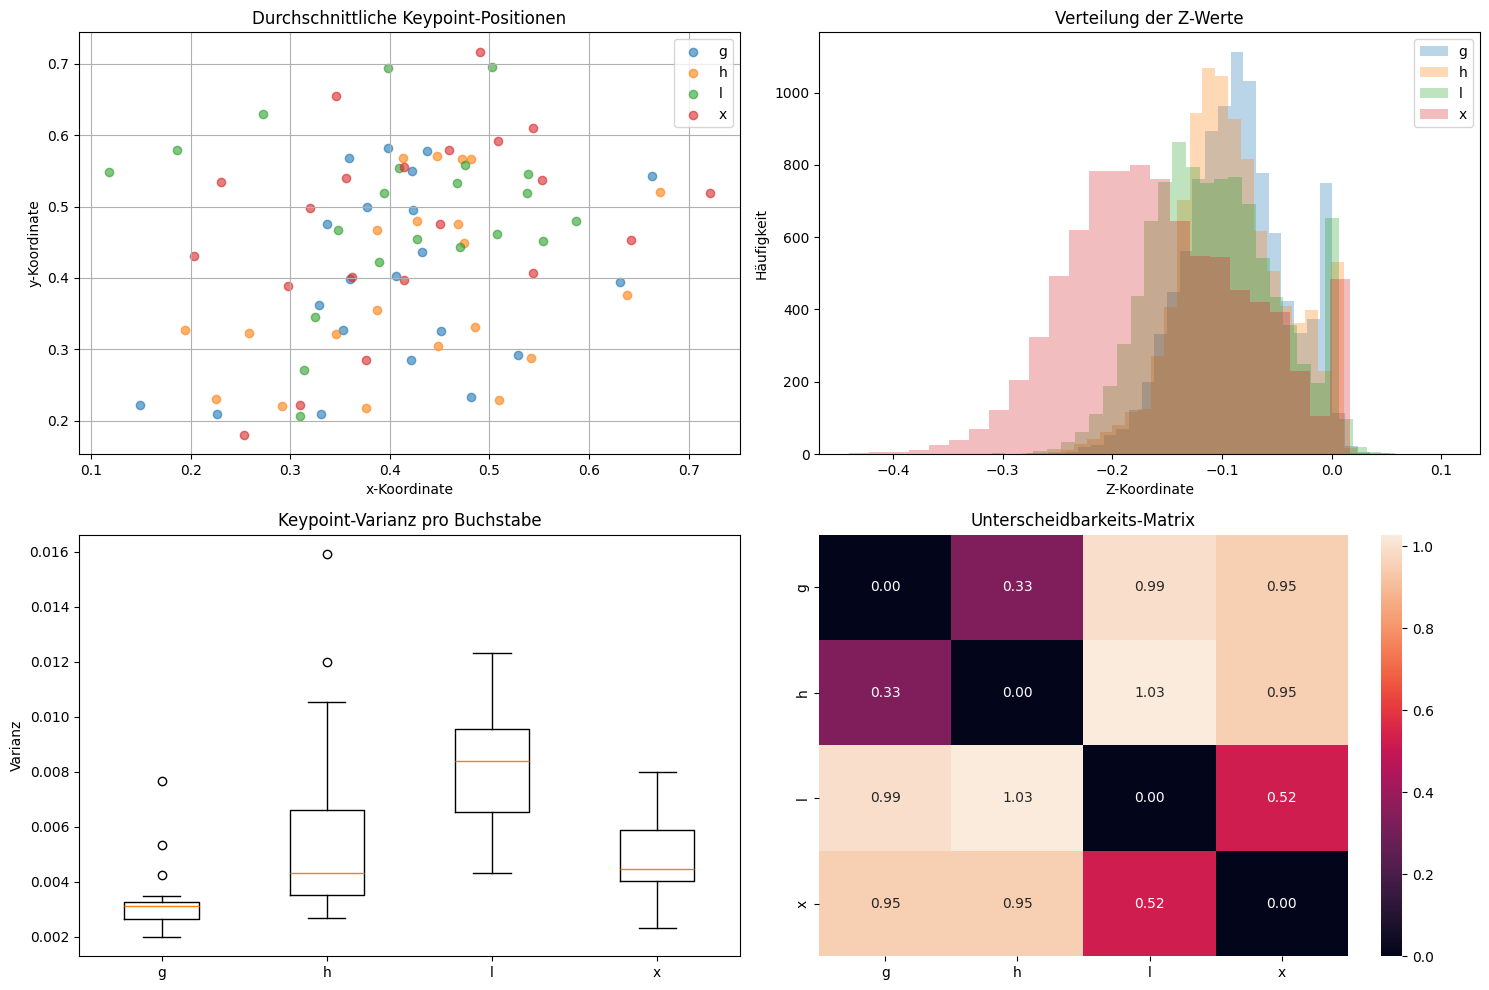

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Lade die Keypoints
data = np.load('/workspaces/asl_detection/machine_learning/datasets/asl_now/Keypoints/asl_keypoints.npz')
keypoints = data['keypoints']
labels = data['labels']

# Buchstaben-Mapping
alphabet = ['g', 'h', 'l', 'x']

print("Grundlegende Informationen:")
print(f"Anzahl Samples: {len(keypoints)}")
print(f"Shape der Keypoints: {keypoints.shape}")
print(f"Samples pro Buchstabe:")
for i, letter in enumerate(alphabet):
    count = np.sum(labels == i)
    print(f"{letter}: {count} Samples")

# Analyse der Keypoint-Verteilung pro Buchstabe
plt.figure(figsize=(15, 10))

# Plot 1: Durchschnittliche Keypoint-Position pro Buchstabe
plt.subplot(221)
for i, letter in enumerate(alphabet):
    letter_keypoints = keypoints[labels == i]
    mean_pos = letter_keypoints.reshape(-1, 21, 3)[:, :, :2].mean(axis=0)
    plt.scatter(mean_pos[:, 0], mean_pos[:, 1], label=letter, alpha=0.6)
plt.title('Durchschnittliche Keypoint-Positionen')
plt.xlabel('x-Koordinate')
plt.ylabel('y-Koordinate')
plt.legend()
plt.grid(True)

# Plot 2: Verteilung der z-Werte
plt.subplot(222)
for i, letter in enumerate(alphabet):
    letter_keypoints = keypoints[labels == i]
    z_values = letter_keypoints.reshape(-1, 21, 3)[:, :, 2]
    plt.hist(z_values.flatten(), bins=30, alpha=0.3, label=letter)
plt.title('Verteilung der Z-Werte')
plt.xlabel('Z-Koordinate')
plt.ylabel('Häufigkeit')
plt.legend()

# Plot 3: Keypoint-Varianz
plt.subplot(223)
variances = []
for i, letter in enumerate(alphabet):
    letter_keypoints = keypoints[labels == i]
    var = letter_keypoints.reshape(-1, 21, 3).var(axis=0)
    variances.append(var.mean(axis=1))

plt.boxplot([v for v in variances], labels=alphabet)
plt.title('Keypoint-Varianz pro Buchstabe')
plt.ylabel('Varianz')

# Plot 4: Konsistenz-Matrix
plt.subplot(224)
consistency = np.zeros((len(alphabet), len(alphabet)))
for i, letter1 in enumerate(alphabet):
    kp1 = keypoints[labels == i].reshape(-1, 21, 3)
    mean1 = kp1.mean(axis=0)
    for j, letter2 in enumerate(alphabet):
        kp2 = keypoints[labels == j].reshape(-1, 21, 3)
        mean2 = kp2.mean(axis=0)
        # Berechne Ähnlichkeit basierend auf euklidischer Distanz
        consistency[i, j] = np.linalg.norm(mean1 - mean2)

sns.heatmap(consistency, annot=True, fmt='.2f', 
            xticklabels=alphabet, yticklabels=alphabet)
plt.title('Unterscheidbarkeits-Matrix')

plt.tight_layout()
plt.savefig('keypoint_analysis_detailed.png')
print("\nDetailierte Analyse wurde als 'keypoint_analysis_detailed.png' gespeichert.")

# Zusätzliche statistische Analysen
print("\nStatistische Analyse:")
print("-" * 50)
for i, letter in enumerate(alphabet):
    letter_keypoints = keypoints[labels == i]
    print(f"\nBuchstabe {letter}:")
    print(f"Min/Max X: {letter_keypoints[:, ::3].min():.3f}/{letter_keypoints[:, ::3].max():.3f}")
    print(f"Min/Max Y: {letter_keypoints[:, 1::3].min():.3f}/{letter_keypoints[:, 1::3].max():.3f}")
    print(f"Min/Max Z: {letter_keypoints[:, 2::3].min():.3f}/{letter_keypoints[:, 2::3].max():.3f}")
    print(f"Durchschnittliche Varianz: {letter_keypoints.var():.3f}") 